In [4]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import random
import torch.nn.functional as F
from gensim.models import FastText
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
!pip install rouge

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data = pd.read_csv('/content/drive/Shareddrives/PMDL-spring21/Phase 2/Reviews.csv')
len(data)

568454

In [8]:
x = data['Text']
y = data['Summary']

In [9]:
def clean(text):
  text = str(text)
  text = text.lower()
  text = re.sub(r'\'s',r'\tis',text)
  text = re.sub(r'\'ll',r'\twill',text)
  text = re.sub(r'\'m',r'\tam',text)
  text = re.sub(r'\'re',r'\tare',text)
  text = re.sub(r'\'d',r'\twould',text)
  text = re.sub(r'n\'t',r'\tnot',text)
  text = re.sub('[^a-zA-Z0-9]',' ',text) 
  text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
  return text

In [10]:
cleaned_source = list(map(clean,x))
cleaned_summary = list(map(clean,y))

for i in range(len(cleaned_summary)):
    cleaned_summary[i] = "<START> " + cleaned_summary[i] + " <END>"
    
print(cleaned_source[11])
print(cleaned_summary[11])

one of my boys needed to lose some weight and the other did not   i put this food on the floor for the chubby guy  and the protein rich  no by product food up higher where only my skinny boy can jump   the higher food sits going stale   they both really go for this food   and my chubby boy has been losing about an ounce a week 
<START> my cats love this  diet  food better than their regular food <END>


In [11]:
min_source_length = 1999999
max_source_length = 0
min_target_length = 199999
max_target_length = 0

for i in range(len(data)):
  min_source_length = min(min_source_length,len(cleaned_source[i].split()))
  min_target_length = min(min_target_length,len(cleaned_summary[i].split()))
  max_source_length = max(max_source_length,len(cleaned_source[i].split()))
  max_target_length = max(max_target_length,len(cleaned_summary[i].split()))

print("Minimum source length is:  ",min_source_length)
print("Minimum target length is:  ",min_target_length)
print("Maximum source length is:  ",max_source_length)
print("Maximum target length is:  ",max_target_length)

Minimum source length is:   3
Minimum target length is:   2
Maximum source length is:   3529
Maximum target length is:   50


In [12]:
new_source = []
new_summary = []

for i in range(len(cleaned_source)):
  if len(cleaned_source[i].split()) <= 50 and len(cleaned_summary[i].split()) <= 15 :
    new_source.append(cleaned_source[i])
    new_summary.append(cleaned_summary[i])

max_source_length = 50
max_summary_length = 15

print(len(new_source))
print(len(new_summary))

new_source = new_source[:30000]
new_summary = new_summary[:30000]

245024
245024


In [13]:
sentences = new_source + new_summary
sent_ted = []
for sent in sentences:
  sent_ted_child = sent.split()
  sent_ted.append(sent_ted_child)

print(sent_ted[0])

['i', 'have', 'bought', 'several', 'of', 'the', 'vitality', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', 'the', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', 'my', 'labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most']


In [14]:
import pickle
model_ted = pickle.load(open('/content/drive/Shareddrives/PMDL-spring21/Phase 2/128_emb.pkl', 'rb'))
weights = model_ted.wv
print(model_ted.wv.most_similar("milk"))

[('skim', 0.5355638265609741), ('milks', 0.5320084095001221), ('water', 0.5292779207229614), ('foggy', 0.5185288190841675), ('creamer', 0.5173667669296265), ('wipping', 0.5089503526687622), ('raisan', 0.5022526383399963), ('floz', 0.4988960325717926), ('truvia', 0.4962727725505829), ('frother', 0.4953957200050354)]


In [15]:
from collections import OrderedDict 

word2Index_enc = {}
word2Index_dec = {}
word2Index_dec_big = {}

ind2Word_enc = {}
ind2Word_dec = {}
ind2Word_dec_big = {}

word2PsuInd_dec = {}
psuInd2Word_dec = {}

encoder_paragraph = list(set((' '.join(new_source)).split()))

decoder_paragraph_list = list((' '.join(new_summary)).split())
decoder_dict = OrderedDict()
for word in decoder_paragraph_list:
  try:
    decoder_dict[word] = decoder_dict[word] + 1
  except:
    decoder_dict[word] = 1

ind2Word_enc[0] = '<UNK>'
ind2Word_dec[0] = '<UNK>'
word2Index_enc['<UNK>'] = 0
word2Index_dec['<UNK>'] = 0
ind2Word_dec_big[0] = '<UNK>'
word2Index_dec_big['<UNK>'] = 0
word2PsuInd_dec['<UNK>'] = 0
psuInd2Word_dec[0] = '<UNK>'

dec_index = 1
for (decoder_dict_word, decoder_dict_number) in decoder_dict.items():
  word2Index_dec_big[decoder_dict_word] = dec_index
  ind2Word_dec_big[dec_index] = decoder_dict_word
  if decoder_dict_number >= 3 :
    word2Index_dec[decoder_dict_word] = dec_index
    ind2Word_dec[dec_index] = decoder_dict_word
    psuedo_index = len(word2PsuInd_dec.keys())
    word2PsuInd_dec[decoder_dict_word] = psuedo_index
    psuInd2Word_dec[psuedo_index] = decoder_dict_word
  dec_index+=1

enc_index = 1
for index,word in enumerate(encoder_paragraph):
  if word != ' ':
    word2Index_enc[word] = enc_index
    ind2Word_enc[enc_index] = word 
    enc_index+=1

In [16]:
encoder_input = [[word2Index_enc[word] for word in sentence.split() if word in word2Index_enc.keys()] for sentence in new_source ]
decoder_input = [[word2Index_dec_big[word] for word in sentence.split() if word in word2Index_dec_big.keys()] for sentence in new_summary ]

In [17]:
encoder_tensor = [torch.tensor(li,dtype=torch.long,device=device).view(-1, 1) for li in encoder_input]
decoder_tensor = [torch.tensor(li,dtype=torch.long,device=device).view(-1, 1) for li in decoder_input]

In [18]:
class Encoder(nn.Module):
  def __init__(self,input_vocab_size,hidden_size,num_layers=1,bidirectional=False):
    super(Encoder,self).__init__()
    self.bidirectional = bidirectional
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.input_vocab_size = input_vocab_size
    self.gru_layer = nn.GRU(input_size = self.hidden_size,hidden_size = self.hidden_size,num_layers = self.num_layers)

  def forward(self,input_,prev_hidden_state):
    input_word = ind2Word_enc[input_.data.tolist()[0]]
    embedded_outputs = torch.tensor(weights[input_word], device = device).view(1,1,-1)
    output,prev_hidden_state = self.gru_layer(embedded_outputs,prev_hidden_state)  #output is batch_size times hidden_size
    return output,prev_hidden_state

  def init_hidden(self):
    return torch.zeros(1,1,self.hidden_size,device=device)

In [19]:
class AttentionDecoder(nn.Module):
  def __init__(self,output_vocab_size,hidden_size,max_length_encoder,dropout_value,num_layers=1):
      super(AttentionDecoder,self).__init__()
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      self.output_vocab_size = output_vocab_size
      self.dropout_p = dropout_value
      self.max_length_encoder = max_length_encoder
      self.embedding_layer = nn.Embedding(self.output_vocab_size,self.hidden_size)
      self.attention_layer = nn.Linear(self.hidden_size*2,self.max_length_encoder)
      self.attention_combine = nn.Linear(self.hidden_size*2,self.hidden_size)

      self.s_layer = nn.Linear(self.hidden_size, 1)
      self.x_layer = nn.Linear(self.hidden_size, 1)
      self.context_layer = nn.Linear(self.hidden_size, 1)
      self.linear_pgen = nn.Linear(3, 1)

      self.gru_layer = nn.GRU(self.hidden_size,self.hidden_size)
      self.output_layer = nn.Linear(self.hidden_size,self.output_vocab_size)
      self.dropout_layer = nn.Dropout(self.dropout_p)    

  def forward(self,input_,prev_hidden_state,encoder_output,prev_unk_word):
      input_word = ind2Word_dec_big[input_.data.tolist()[0]]
      if input_word == '<UNK>':
        embedded_outputs = torch.tensor(weights[prev_unk_word], device = device).view(1,1,-1)
      else:
        embedded_outputs = torch.tensor(weights[input_word], device = device).view(1,1,-1)
        
      embeddings_dropout = self.dropout_layer(embedded_outputs)
      attention_layer_output = self.attention_layer(torch.cat((embeddings_dropout[0],prev_hidden_state[0]),1))
      attention_weights = nn.functional.softmax(attention_layer_output,dim=1)
      attention_applied = torch.bmm(attention_weights.unsqueeze(0),encoder_output.unsqueeze(0))
      attention_combine_logits = self.attention_combine(torch.cat((embeddings_dropout[0],attention_applied[0]),1)).unsqueeze(0)  #since gru requires a batch dimension
      attention_combine_relu = nn.functional.relu(attention_combine_logits)

      s_output = self.s_layer(prev_hidden_state[0])
      x_output = self.x_layer(embeddings_dropout[0])
      context = torch.flatten(attention_applied)
      context_weights = self.context_layer(attention_applied)
      sx = torch.cat((s_output[0],x_output[0]),0)
      sxc = torch.cat((sx,context_weights[0][0]),0)
      linear_pgen = self.linear_pgen(sxc)
      m = nn.Sigmoid()
      pgen = m(linear_pgen)

      output,hidden = self.gru_layer(attention_combine_relu,prev_hidden_state)
      output_logits = self.output_layer(output)
      output_softmax = nn.functional.log_softmax(output_logits[0],dim=1)
      return output_softmax,hidden,attention_weights,pgen

  def init_hidden(self):
    return torch.zeros(1,1,self.hidden_size,device=device)

In [20]:
teacher_forcing_ratio = 0.5

def train(encoder, decoder, input_tensor, target_tensor, encoder_optimizer, decoder_optimizer, criterion, max_length, iters):

  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  prev_unk_word = ''

  encoder_hidden = encoder.init_hidden()

  encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device = device)

  input_length = input_tensor.size(0)
  output_length = target_tensor.size(0)

  loss = 0

  for encoder_index in range(0, input_length):
    encoder_output,encoder_hidden = encoder(input_tensor[encoder_index], encoder_hidden)
    encoder_outputs[encoder_index] = encoder_output[0,0]

  decoder_input = torch.tensor([word2Index_dec['<START>']],device=device)   
  decoder_hidden = encoder_hidden
  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

  extended_vocab = psuInd2Word_dec.copy()
  reverse_extended_vocab = word2PsuInd_dec.copy()
  duplicate_words = {}
  extend_key = len(word2Index_dec.keys())
  input_list = input_tensor.tolist()
  i =0
  for input_word in input_list:
    if ind2Word_enc[input_word[0]] in word2Index_dec.keys():
      duplicate_words[i] = word2PsuInd_dec[ind2Word_enc[input_word[0]]]
    else:
      extended_vocab[extend_key] = ind2Word_enc[input_word[0]]
      reverse_extended_vocab[ind2Word_enc[input_word[0]]] = extend_key
      extend_key += 1
    i = i+1

  if use_teacher_forcing:
    for decoder_index in range(output_length):
      decoder_output,decoder_hidden,decoder_attention,pgen = decoder(decoder_input,decoder_hidden,encoder_outputs,prev_unk_word)
      P_over_extended_vocab = torch.exp(decoder_output)*pgen.expand_as(torch.exp(decoder_output))

      decoder_attention = decoder_attention.squeeze(0)[0:input_length].unsqueeze(0)
      p_duplicate_list = torch.zeros([input_length, P_over_extended_vocab.size(1)], device=device)
      p_duplicate_list = p_duplicate_list.tolist()
      for (duplicate_word_key,duplicate_word_value) in duplicate_words.items():
        p_duplicate_list[duplicate_word_key][duplicate_word_value] = 1
      p_duplicate = torch.tensor(p_duplicate_list, dtype=torch.float, device=device)
      p_diag = torch.mm(decoder_attention, p_duplicate)
      p_diag = p_diag*(torch.tensor([1], device=device).sub(pgen)).expand_as(p_diag)
      p_add_diag = torch.diag(p_diag.squeeze(0),diagonal=0)
      P_over_extended_vocab = torch.mm(P_over_extended_vocab,p_add_diag).add(P_over_extended_vocab)

      for i in range(input_length):
        if not (1 in p_duplicate_list[i]):
          P_over_extended_vocab = torch.cat((P_over_extended_vocab[0], torch.mm(decoder_attention.squeeze(0)[i].unsqueeze(0).unsqueeze(0), torch.tensor([1], device=device).sub(pgen).unsqueeze(0)).squeeze(0)),0).unsqueeze(0)

      try:
        loss += -torch.log(P_over_extended_vocab[0][ reverse_extended_vocab[ ind2Word_dec_big[ target_tensor[decoder_index].item() ] ] ] + 1e-12)
        loss.backward(retain_graph=True)
      except KeyError:
        loss += torch.tensor(0,dtype=torch.float,device=device)
      decoder_input = target_tensor[decoder_index]
  else:

    for decoder_index in range(output_length):
      decoder_output,decoder_hidden,decoder_attention,pgen = decoder(decoder_input,decoder_hidden,encoder_outputs,prev_unk_word) 
      P_over_extended_vocab = torch.exp(decoder_output)*pgen.expand_as(torch.exp(decoder_output))

      decoder_attention = decoder_attention.squeeze(0)[0:input_length].unsqueeze(0)
      p_duplicate_list = torch.zeros([input_length, P_over_extended_vocab.size(1)], device=device)
      p_duplicate_list = p_duplicate_list.tolist()
      for (duplicate_word_key,duplicate_word_value) in duplicate_words.items():
        p_duplicate_list[duplicate_word_key][duplicate_word_value] = 1
      p_duplicate = torch.tensor(p_duplicate_list, dtype=torch.float, device=device)
      p_diag = torch.mm(decoder_attention, p_duplicate)
      p_diag = p_diag*(torch.tensor([1], device=device).sub(pgen)).expand_as(p_diag)
      p_add_diag = torch.diag(p_diag.squeeze(0),diagonal=0)
      P_over_extended_vocab = torch.mm(P_over_extended_vocab,p_add_diag).add(P_over_extended_vocab)

      for i in range(input_length):
        if not (1 in p_duplicate_list[i]):
          P_over_extended_vocab = torch.cat((P_over_extended_vocab[0], torch.mm(decoder_attention.squeeze(0)[i].unsqueeze(0).unsqueeze(0), torch.tensor([1], device=device).sub(pgen).unsqueeze(0)).squeeze(0)),0).unsqueeze(0)

      try:
        loss += -torch.log(P_over_extended_vocab[0][ reverse_extended_vocab[ ind2Word_dec_big[ target_tensor[decoder_index].item() ] ] ] + 1e-12)
        loss.backward(retain_graph=True)
      except KeyError:
        loss += torch.tensor(0,dtype=torch.float,device=device)
      idx = torch.topk(P_over_extended_vocab, k=1, dim=1)[1]
      if idx.item() < len(word2Index_dec.keys()):   
        decoder_input = torch.tensor([idx.item()],dtype=torch.long,device=device)
      elif idx.item() >= len(word2Index_dec.keys()):
        prev_unk_word = extended_vocab[idx.item()]
        decoder_input = torch.tensor([0],dtype=torch.long,device=device)
      elif (decoder_input.item() == word2Index_dec['<END>']):
        break

  if iters > 20000:
    torch.nn.utils.clip_grad_norm_(rnn_encoder.parameters(),0.4)
    torch.nn.utils.clip_grad_norm_(rnn_decoder.parameters(),0.4)

  encoder_optimizer.step()
  decoder_optimizer.step()

  return loss.item()/output_length

In [21]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    if percent != 0:
      es = s / (percent)
      rs = es - s
      return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
    else:
      return 0

In [22]:
arr = np.arange(len(encoder_tensor))
np.random.shuffle(arr)
len(arr)

30000

In [23]:
# Dictionary for creating loss graph
loss_graph = {}

def train_Iters(encoder,decoder,n_iters,print_every=50, plot_every=100,learning_rate = 0.03):
  # start = time.time()
  plot_losses = []
  print_loss_total = 0  # Reset every print_every
  plot_loss_total = 0

  encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
  training_pairs = [random.choice(pairs) for i in range(n_iters)]
  
  criterion = nn.NLLLoss()
  for iters in range(n_iters):
    training_pair = training_pairs[iters - 1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]

    input_tensor = torch.tensor(input_tensor, dtype=torch.long, device = device).view(-1, 1)
    target_tensor = torch.tensor(target_tensor, dtype=torch.long, device = device).view(-1, 1)

    loss = train(encoder,decoder,input_tensor,target_tensor,encoder_optimizer,decoder_optimizer,criterion,max_source_length, iters)
    print_loss_total += loss
    plot_loss_total += loss

    if iters % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print('%s %d%%) %.4f' % (iters, iters / len(arr) * 100, print_loss_avg))

        if iters > 0:
          loss_graph[iters] = print_loss_avg

    if iters % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

        #return loss

In [24]:
%matplotlib inline 

from matplotlib import pyplot
pyplot.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    pyplot.figure()
    fig, ax = pyplot.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    pyplot.plot(points)

In [25]:
pairs = []
for enc,dec in zip(encoder_input,decoder_input):
    pairs.append([enc,dec])

In [26]:
hidden_size = 128
rnn_encoder = Encoder(len(word2Index_enc.keys()),hidden_size).to(device=device)
rnn_decoder = AttentionDecoder(len(word2Index_dec.keys()),hidden_size,max_source_length,0.2).to(device=device)

train_Iters(rnn_encoder,rnn_decoder,5000)


0 0%) 0.1714
50 0%) 5.6345
100 0%) 5.8225
150 0%) 4.8406
200 0%) 4.6814
250 0%) 4.6415
300 1%) 4.4091
350 1%) 4.1923
400 1%) 4.2697
450 1%) 4.0123
500 1%) 4.4203
550 1%) 4.1832
600 2%) 4.1844
650 2%) 4.0388
700 2%) 3.8069
750 2%) 4.5407
800 2%) 4.2120
850 2%) 4.2045
900 3%) 4.3148
950 3%) 4.0410
1000 3%) 4.1084
1050 3%) 4.1745
1100 3%) 4.2969
1150 3%) 4.1750
1200 4%) 4.1161
1250 4%) 4.0516
1300 4%) 3.6885
1350 4%) 3.8702
1400 4%) 3.9003
1450 4%) 4.0120
1500 5%) 3.5711
1550 5%) 4.0104
1600 5%) 4.0868
1650 5%) 4.1342
1700 5%) 4.1491
1750 5%) 4.1815
1800 6%) 4.1689
1850 6%) 3.7660
1900 6%) 3.8036
1950 6%) 4.0518
2000 6%) 4.0994
2050 6%) 4.1529
2100 7%) 3.8653
2150 7%) 4.4184
2200 7%) 4.0327
2250 7%) 3.8252
2300 7%) 4.1519
2350 7%) 4.1808
2400 8%) 3.9145
2450 8%) 3.8470
2500 8%) 3.9639
2550 8%) 3.8149
2600 8%) 4.0914
2650 8%) 4.0173
2700 9%) 4.3018
2750 9%) 3.9788
2800 9%) 3.8191
2850 9%) 4.2253
2900 9%) 3.9007
2950 9%) 3.9921
3000 10%) 3.9084
3050 10%) 3.7970
3100 10%) 3.8932
3150 10%) 4.

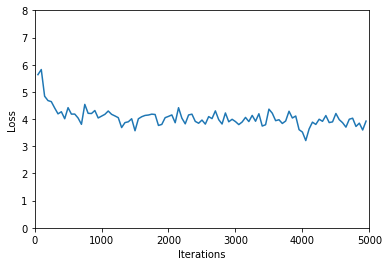

In [27]:
%matplotlib inline 

import matplotlib.pyplot as plt

iters = list(loss_graph.keys())
loss_val = list(loss_graph.values())
plt.plot(iters, loss_val)
plt.ylim(0,8) 
plt.xlim(0,5000)
plt.xlabel('Iterations') 
plt.ylabel('Loss')  
plt.show()



In [28]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge 
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        pair1 = torch.tensor(pair[0],dtype=torch.long,device=device)
        pair2 = pair[1]
        output_words, attentions = evaluate(encoder, decoder, pair1)
        output_sentence = ' '.join(output_words)
        output_list = [ind2Word_dec_big[word] for word in pair2]
        output_list = ' '.join(output_list)
        input_sentence = [ind2Word_enc[element.item()] for element in pair1.flatten()]
        input_sentence = ' '.join(input_sentence)
        #print("Sentence is  ",input_sentence)
        #print('<',output_sentence)
        #print('=',output_list)
        print("Review:",input_sentence)
        #print("Original summary:",output_sentence)
        print("Predicted summary:",output_list)
        scoreB = sentence_bleu(output_sentence, output_list)
        rouge = Rouge()
        scoreR = rouge.get_scores(output_sentence, output_list)
        print(scoreB)
        print(scoreR)
        print("\n")

In [29]:
def evaluate(encoder, decoder, encoder_tensor, max_length=max_source_length):
    with torch.no_grad():
        input_tensor = encoder_tensor
        input_length = input_tensor.size(0)
        encoder_hidden = encoder.init_hidden()

        prev_unk_word = ''

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0),
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        extended_vocab = psuInd2Word_dec.copy()
        duplicate_words = {}
        extend_key = len(word2Index_dec.keys())
        input_list = input_tensor.tolist()
        i =0
        for input_word in input_list:
          if ind2Word_enc[input_word] in word2Index_dec.keys():
            duplicate_words[i] = word2PsuInd_dec[ind2Word_enc[input_word]]
          else:
            extended_vocab[extend_key] = ind2Word_enc[input_word]
            extend_key += 1
          i = i+1

        decoder_input = torch.tensor([word2Index_dec['<START>']], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention,pgen = decoder(
                decoder_input, decoder_hidden, encoder_outputs, prev_unk_word)
            decoder_attentions[di] = decoder_attention.data

            P_over_extended_vocab = torch.exp(decoder_output)*pgen.expand_as(torch.exp(decoder_output))

            decoder_attention = decoder_attention.squeeze(0)[0:input_length].unsqueeze(0)
            p_duplicate_list = torch.zeros([input_length, P_over_extended_vocab.size(1)], device=device)
            p_duplicate_list = p_duplicate_list.tolist()
            for (duplicate_word_key,duplicate_word_value) in duplicate_words.items():
              p_duplicate_list[duplicate_word_key][duplicate_word_value] = 1
            p_duplicate = torch.tensor(p_duplicate_list, dtype=torch.float, device=device)
            p_diag = torch.mm(decoder_attention, p_duplicate)
            p_diag = p_diag*(torch.tensor([1], device=device).sub(pgen)).expand_as(p_diag)
            p_add_diag = torch.diag(p_diag.squeeze(0),diagonal=0)
            P_over_extended_vocab = torch.mm(P_over_extended_vocab,p_add_diag).add(P_over_extended_vocab)

            for i in range(input_length):
              if not (1 in p_duplicate_list[i]):
                P_over_extended_vocab = torch.cat((P_over_extended_vocab[0], torch.mm(decoder_attention.squeeze(0)[i].unsqueeze(0).unsqueeze(0), torch.tensor([1], device=device).sub(pgen).unsqueeze(0)).squeeze(0)),0).unsqueeze(0)

            idx = torch.topk(P_over_extended_vocab, k=1, dim=1)[1]
            if idx.item() < len(word2Index_dec.keys()):   
              decoder_input = torch.tensor([idx.item()],dtype=torch.long,device=device)
              decoded_words.append(extended_vocab[idx.item()])
            elif idx.item() >= len(word2Index_dec.keys()):
              decoder_input = torch.tensor([0],dtype=torch.long,device=device)
              prev_unk_word = extended_vocab[idx.item()]
              decoded_words.append(extended_vocab[idx.item()])
            if idx.item() == word2Index_dec['<END>']:
              decoded_words.append('<END>')
              break

        return decoded_words, decoder_attentions[:di + 1]

In [30]:
evaluateRandomly(rnn_encoder, rnn_decoder)

Review: my daughter loved this cotton candy it was hard to find in the stores but am glad we found it online
Predicted summary: <START> my daughter loved this <END>
0.8034284189446518
[{'rouge-1': {'f': 0.39999999520000007, 'p': 0.5, 'r': 0.3333333333333333}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.44444444000000005, 'p': 0.6666666666666666, 'r': 0.3333333333333333}}]


Review: deliciously sweet and chocolate y while having essentially the same nutritional bang for your caloric buck as plain almonds a great product
Predicted summary: <START> delicious <END>
0.8316033157750904
[{'rouge-1': {'f': 0.5714285665306124, 'p': 0.5, 'r': 0.6666666666666666}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.6666666616666668, 'p': 0.6666666666666666, 'r': 0.6666666666666666}}]


Review: my children love the taste better than milk from grocery store and it is good for us to travel out of the country
Predicted summary: <START> good product <END>
0.8408964152537145

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Review: wolfgang puck is hawaiian hazelnut is the best k cup hazelnut and i have tried them all we ordered this large pack because we sadly found out that wolfgang puck is discontinuing many not all of their k cups including this flavor buy this while you can
Predicted summary: <START> the best hazelnut k cup <END>
0.7699019277569183
[{'rouge-1': {'f': 0.36363635900826446, 'p': 0.5, 'r': 0.2857142857142857}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.3999999958, 'p': 0.6666666666666666, 'r': 0.2857142857142857}}]


Review: i thought it was great if your want hot this is just for you just one word for this item great
Predicted summary: <START> bhut jolokia powder <END>
0.8070557274927981
[{'rouge-1': {'f': 0.4444444395061729, 'p': 0.5, 'r': 0.4}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.49999999531250006, 'p': 0.6666666666666666, 'r': 0.4}}]


